Scaling Factor 0.5: PSNR=35.81, SSIM=0.9601
Scaling Factor 1: PSNR=32.51, SSIM=0.9328
Scaling Factor 2: PSNR=29.29, SSIM=0.8855
Scaling Factor 4: PSNR=26.25, SSIM=0.8033
Scaling Factor 8: PSNR=23.92, SSIM=0.6753


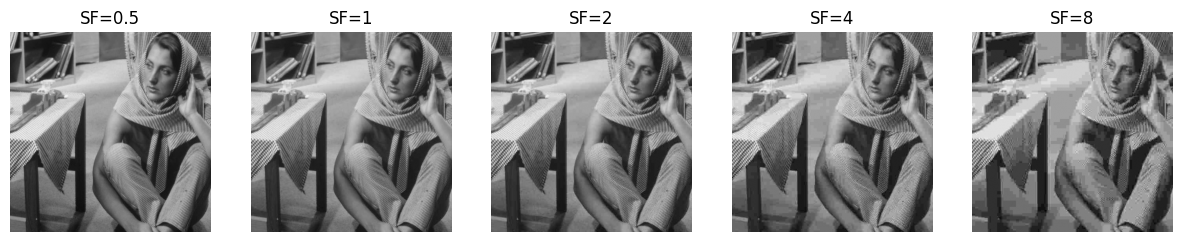

In [64]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2

def block_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def block_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def zigzag(block):
    zigzag_order = [
        (0,0),(0,1),(1,0),(2,0),(1,1),(0,2),(0,3),(1,2),
        (2,1),(3,0),(4,0),(3,1),(2,2),(1,3),(0,4),(0,5),
        (1,4),(2,3),(3,2),(4,1),(5,0),(6,0),(5,1),(4,2),
        (3,3),(2,4),(1,5),(0,6),(0,7),(1,6),(2,5),(3,4),
        (4,3),(5,2),(6,1),(7,0),(7,1),(6,2),(5,3),(4,4),
        (3,5),(2,6),(1,7),(2,7),(3,6),(4,5),(5,4),(6,3),
        (7,2),(7,3),(6,4),(5,5),(4,6),(3,7),(4,7),(5,6),
        (6,5),(7,4),(7,5),(6,6),(5,7),(6,7),(7,6),(7,7)
    ]
    return [block[i][j] for i,j in zigzag_order]

def inverse_zigzag(array):
    block = np.zeros((8,8))
    zigzag_order = [
        (0,0),(0,1),(1,0),(2,0),(1,1),(0,2),(0,3),(1,2),
        (2,1),(3,0),(4,0),(3,1),(2,2),(1,3),(0,4),(0,5),
        (1,4),(2,3),(3,2),(4,1),(5,0),(6,0),(5,1),(4,2),
        (3,3),(2,4),(1,5),(0,6),(0,7),(1,6),(2,5),(3,4),
        (4,3),(5,2),(6,1),(7,0),(7,1),(6,2),(5,3),(4,4),
        (3,5),(2,6),(1,7),(2,7),(3,6),(4,5),(5,4),(6,3),
        (7,2),(7,3),(6,4),(5,5),(4,6),(3,7),(4,7),(5,6),
        (6,5),(7,4),(7,5),(6,6),(5,7),(6,7),(7,6),(7,7)
    ]
    for idx, (i,j) in enumerate(zigzag_order):
        block[i][j] = array[idx]
    return block

def rle_encode(block):
    result = []
    zeros = 0
    for i, val in enumerate(block):
        if i == 0:
            result.append(val)
            continue
        if val == 0:
            zeros += 1
        else:
            if zeros > 0:
                result.append((0, zeros))  # zero run
                zeros = 0
            result.append(val)
    if zeros > 0:
        result.append((0, zeros))
    return result

def rle_decode(rle, size=64):
    block = []
    for item in rle:
        if isinstance(item, tuple):  # (0, run)
            block.extend([0] * item[1])
        else:
            block.append(item)
    block.extend([0] * (size - len(block)))
    return block

Q = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

scaling_factors = [0.5, 1, 2, 4, 8]


image = Image.open("imgB_prenoise.png").convert("L")
img_arr = np.array(image, dtype=np.float32)
h, w = img_arr.shape

results = []

for sf in scaling_factors:
    Q_scaled = (Q * sf).astype(int)
    reconstructed = np.zeros_like(img_arr)


    for y in range(0, h, 8):
        for x in range(0, w, 8):
            block = img_arr[y:y+8, x:x+8]
            if block.shape != (8,8):
                padded = np.zeros((8,8))
                padded[:block.shape[0], :block.shape[1]] = block
                block = padded

            dct_block = block_dct(block - 128)
            quantized = np.round(dct_block / Q_scaled)
            zz = zigzag(quantized)
            rle = rle_encode(zz)


            decoded = rle_decode(rle)
            dezigzag = inverse_zigzag(decoded)
            dequantized = dezigzag * Q_scaled
            idct_block = block_idct(dequantized) + 128


            reconstructed[y:y+8, x:x+8] = np.clip(idct_block, 0, 255)

    reconstructed = reconstructed.astype(np.uint8)
    Image.fromarray(reconstructed).save(f"reconstructed_sf{sf}.png")

    psnr_val = psnr(img_arr.astype(np.uint8), reconstructed, data_range=255)
    ssim_val = ssim(img_arr.astype(np.uint8), reconstructed, data_range=255)


    results.append((sf, psnr_val, ssim_val))
    print(f"Scaling Factor {sf}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")

plt.figure(figsize=(15,6))
for i, sf in enumerate(scaling_factors):
    img = Image.open(f"reconstructed_sf{sf}.png")
    plt.subplot(1, len(scaling_factors), i+1)
    plt.title(f"SF={sf}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")



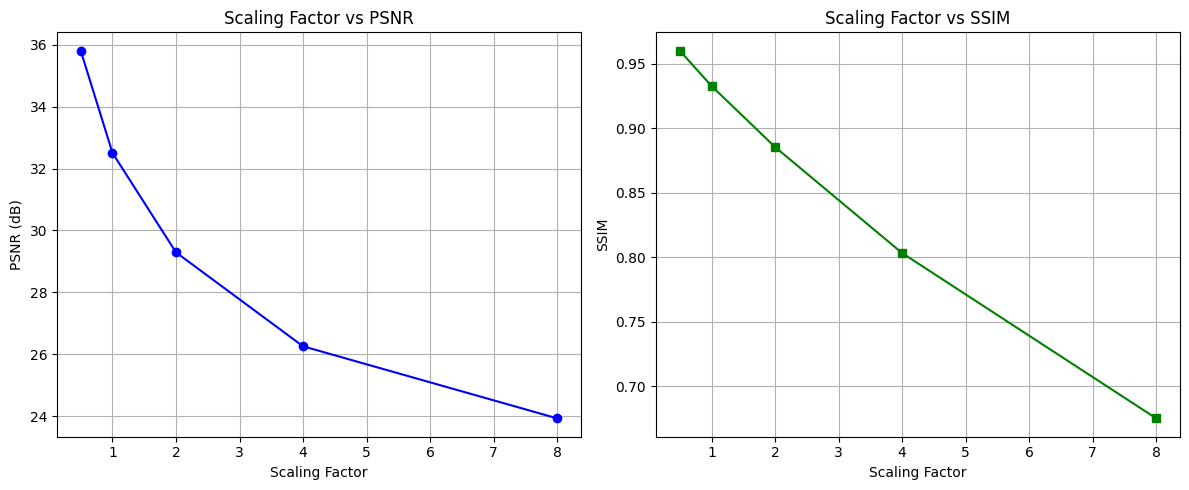

In [65]:

scales = [r[0] for r in results]
psnr_vals = [r[1] for r in results]
ssim_vals = [r[2] for r in results]

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(scales, psnr_vals, marker='o', linestyle='-', color='b')
plt.title("Scaling Factor vs PSNR")
plt.xlabel("Scaling Factor")
plt.ylabel("PSNR (dB)")
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(scales, ssim_vals, marker='s', linestyle='-', color='g')
plt.title("Scaling Factor vs SSIM")
plt.xlabel("Scaling Factor")
plt.ylabel("SSIM")
plt.grid(True)

plt.tight_layout()
plt.show()
